# Simple 1-D example for HMRF-GMM


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Set up synthetic model

We start with a simple model with only two possible outcomes and two feautres:

In [4]:
import scipy.stats as stats

In [5]:
np.random.seed(12345)
# define domain
x_pos = np.arange(1000)
latent_1D = np.zeros_like(x_pos)
dist = stats.bernoulli(0.01)
val = 0
for i in range(len(x_pos)):
    if dist.rvs():
        val = 1 - val
    latent_1D[i] = val
        

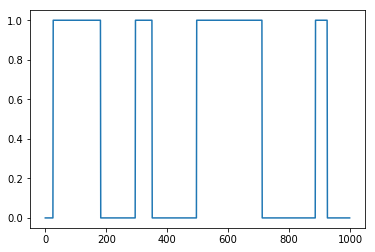

In [6]:
plt.plot(latent_1D)

## Feature classes

Now generate feature classes. Each class has one $\mu$ value and one covariance matrix for each latent variable:



In [7]:
# define statistics of class 1:
class ClassDensity(object):
    
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        
    def rvs(self):
        """Generate random values"""
        
        
        
        
        

Example from `toy_example.m`

```
mu=[6 9;4 12;9 14];
SIGMA(2,2,3)=0;
SIGMA(:,:,1)=3*[0.5625 0.225; 0.225 0.675];
SIGMA(:,:,2)=3*[1.125 0.225; 0.225 0.675];
SIGMA(:,:,3)=3*[0.5625 0.0225; 0.0225 0.675];

```

In [8]:
c1 = ClassDensity(np.array([6,9]),
                 np.array([[[0.5625, 0.225],[0.225, 0.675]],
                          [[0.5625, 0.225],[0.225, 0.675]]]))

c2 = ClassDensity(np.array([4,12]),
                 np.array([[[1.125, 0.225],[0.225, 0.675]],
                          [[1.125, 0.225],[0.225, 0.675]]]))

In [9]:
c1.cov, c1.mu

(array([[[ 0.5625,  0.225 ],
         [ 0.225 ,  0.675 ]],
 
        [[ 0.5625,  0.225 ],
         [ 0.225 ,  0.675 ]]]), array([6, 9]))

In [ ]:
x1, y1 = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
rv = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
plt.contourf(x1, y1, rv.pdf(pos))


In [1]:
c1 = stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])

NameError: name 'stats' is not defined

In [534]:
c2 = stats.multivariate_normal([4,12], [[1.125, 0.225],[0.225, 0.675]])
# FW: try different means for a more difficult estimation:
# c2 = stats.multivariate_normal([5,10], [[1.125, 0.225],[0.225, 0.675]])


c3 = stats.multivariate_normal([9,14], [[0.5625, 0.0225],[0.0225, 0.675]])

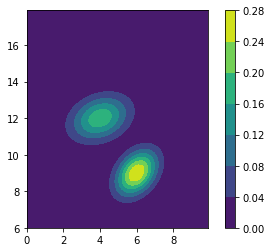

In [535]:
x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

## Generate samples according to latent field

In [536]:
# for 

observed_field = np.empty((len(x_pos), 2))

for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        observed_field[i,:] = c1.rvs()
    elif l == 1:
        observed_field[i,:] = c2.rvs()
    
    

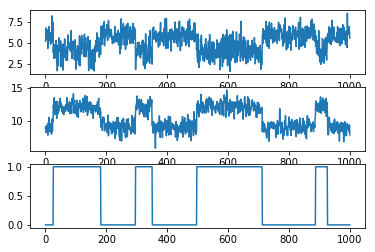

In [537]:
fig, ax = plt.subplots(3,1)
ax[0].plot(observed_field[:,0])
ax[1].plot(observed_field[:,1])
ax[2].plot(latent_1D)

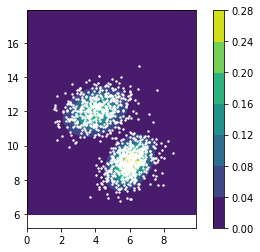

In [538]:
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()
plt.scatter(observed_field[:,0], observed_field[:,1], c='w', s=2)


## Construct cell structure

We now need to define the neighborhood system

In [539]:
class Element(object):
    
    def __init__(self, pos, center):
        """Define Element structure"""
        self.pos = pos
        self.center = center
        # self.neighbors = neighbors
        # self.color = color
        # self.label = np.random.randint(1)
        # self.energy = energy
        # self.entropy = entropy
        # self.prob = prob
        self.neighbors = []
        # self.beta # correlation strength
        self.element_energy = 0. # to allow a more complex implemenation later - for now simply 0
        
    def __repr__(self):
        """Generate meaningful output of element"""
        s = "Element at pos %d " % self.pos
        if hasattr(self, "values"):
            s += "with values "
            for val in self.values:
                s += "%f, " % val
        if hasattr(self, "label"):
            s += "and current label %d" % self.label
        return s
    
        
    def update_label(self, clf):
        """Update label according to classifyer object"""
        self.label = clf.predict(np.array([[self.values[0]], [self.values[1]]]).T)
        
    def calculate_energy(self, beta, mu, beta):
        """Determine energy of element according to neighbouring structure"""
        # MRF energy
        MRF = 0.
        for n in self.neigbors:
            if n.label != self.label:
                MRF += beta
        
        # likelihood energy
        U_like = 0.5 * (self.values - mu[self.label,:])
        
        U = self.element_energy + MRF + U
        
        
        
    

In [540]:
import scipy.spatial.distance as d

In [541]:
# iterate through our grid/ domain and set up element structure
all_elements = []

for i,xx in enumerate(x_pos):
    # create element
    tmp_element = Element(i, xx)
    all_elements.append(tmp_element)
    
# now: add neighbors
for i,xx in enumerate(x_pos):
    if i == 0:
        all_elements[i].neighbors.append(all_elements[1])
    elif i == len(x_pos)-1:
        all_elements[i].neighbors.append(all_elements[-1])
    else:
        all_elements[i].neighbors.append(all_elements[i-1])
        all_elements[i].neighbors.append(all_elements[i+1])
        
    # update number of degree
    all_elements[i].degree = len(all_elements[i].neighbors)

<div class="alert alert-warning">*To Do Florian*: define general methods to find neighbors based on distances</div>

## Determine element color

Used for later parallelisation (here: simply changing)

In [542]:
for i,e in enumerate(all_elements):
    if np.mod(i,2) == 0:
        e.color = 0
    else:
        e.color = 1

### Assign obervation value to elements

Each element also contains the information about its observed value(s) - so, in our case the two features:

In [543]:
for i,e in enumerate(all_elements):
    e.values = observed_field[i,:]

In [544]:
observed_field[60:70,:]

array([[  4.15395541,  10.91300968],
       [  4.84807097,  11.88333671],
       [  4.66559431,  11.49422447],
       [  5.47484415,  11.51133829],
       [  5.1163413 ,  12.15000214],
       [  3.20260119,  11.71953963],
       [  3.51084884,  11.39703381],
       [  4.16726732,  12.40527494],
       [  2.88025065,  11.74650886],
       [  3.89011488,  12.012853  ]])

In [545]:
len(all_elements)

1000

# First round: initialise with gmm

Aim: find initial labels for all elements using gmm

In [546]:
print(e)

Element at pos 999 with values 5.578461, 7.849046, 


In [547]:
# fit a Gaussian Mixture Model with two components
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')

In [548]:
# additional step: scale data?
# from sklearn import preprocessing
# 
# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)

In [549]:
# here: simply assign data array
scaled_data2 = observed_field

In [550]:
clf.fit(scaled_data2)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

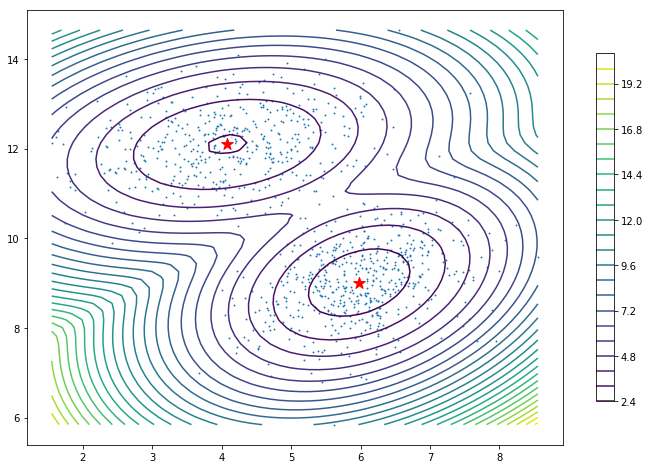

In [551]:
# display predicted scores by the model as a contour plot
from matplotlib.colors import LogNorm
plt.figure(figsize=(12,8))

x = np.linspace(np.min(scaled_data2[:,0]), np.max(scaled_data2[:,0]))
y = np.linspace(np.min(scaled_data2[:,1]), np.max(scaled_data2[:,1]))
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                   levels=np.logspace(0, 3, 20))
CS = plt.contour(X,Y,Z,30)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(scaled_data2[:, 0], scaled_data2[:, 1], .8)
# plot means
for cx,cy in clf.means_:
    plt.scatter(cx, cy, marker='o', s=200, c='w')
    plt.scatter(cx, cy, marker='*', s=150, c='r')

In [552]:
print(clf.means_)
print(clf.covariances_)

[[  5.98067397   9.01298327]
 [  4.07865176  12.09400085]]
[[[ 0.62805456  0.2166607 ]
  [ 0.2166607   0.66879647]]

 [[ 1.08816905  0.19824496]
  [ 0.19824496  0.60439024]]]


In [553]:
c1.mean, c2.mean

(array([ 6.,  9.]), array([  4.,  12.]))

In [554]:
c1.cov, c2.cov

(array([[ 0.5625,  0.225 ],
        [ 0.225 ,  0.675 ]]), array([[ 1.125,  0.225],
        [ 0.225,  0.675]]))

So, obviously, the fit is really good in this case - as the problem is easy to separate in feature space...

### Assign labels to elements according gmm fit


In [555]:
for i,e in enumerate(all_elements):
    e.update_label(clf)

Create a plot of current classification and true labels:

In [556]:
latent_current = [e.label for e in all_elements]

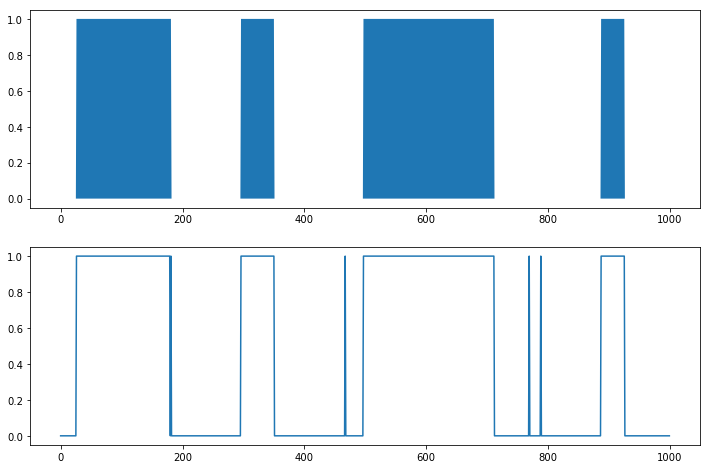

In [557]:
latent_current = [e.label for e in all_elements]
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].fill_between(x_pos, latent_1D)
ax[1].plot(x_pos, np.array(latent_current))

### Define initial mu, cov according to gmm fit

## Global parameters

- $\boldsymbol{mu}$: vector of mean values for features for all clusters (n x p matrix: n: number of clusters, p: number of features)
- $\boldsymbol{\Sigma}$: covariance matrix, (p x p x n)
- $\beta$: correlation strength (scalar)

In [568]:
mu_all = []
cov_all = []
beta_all = []
# initialise values
mu_init = clf.means_   # first axis: cluster label, second axis: feature
cov_init = clf.covariances_ # first axis: cluster label, second and third axes: feature covariances

In [567]:
# as an example: these are the mean values for the first label (0):
mu_init[0,:] 

array([ 5.98067397,  9.01298327])

In [576]:
# these are the cov matrix values for the first label (0):
print(cov_init[0,:,:])
# and here for label (1)
print(cov_init[1,:,:])

[[ 0.62805456  0.2166607 ]
 [ 0.2166607   0.66879647]]
[[ 1.08816905  0.19824496]
 [ 0.19824496  0.60439024]]


Compare to defined covariances:

```
SIGMA(:,:,1)=3*[0.5625 0.225; 0.225 0.675];
SIGMA(:,:,2)=3*[1.125 0.225; 0.225 0.675];
```

## Update energy

The element energy consists of three parts:

1. element self-energy (here set to 0, just included for later extension)
2. MRF-energy
3. Likelihood energy

In [598]:
# as an example: use element 1:
e1 = all_elements[30]
# and set mu and cov and beta to initial values first:
mu = mu_init
cov = cov_init
beta = 0.5

In [599]:
e1, e1.label, e1.neighbors

(Element at pos 30 with values 3.977756, 11.285501, and current label 1,
 array([1]),
 [Element at pos 29 with values 4.740367, 13.482293, and current label 1,
  Element at pos 31 with values 4.742161, 11.796273, and current label 1])

In [600]:
e1

Element at pos 30 with values 3.977756, 11.285501, and current label 1

As a first step: calculate MRF energy.

<div class="alert alert-warning">**Note**: this step should be vectorised later for higher efficiency!</div>

In [616]:

# calculate MRF energy:
U_MRF = 0.
for n in e1.neighbors:
    if n.label != e1.label:
        U_MRF += beta


Define likelihood energy:

(see eq. (29) in paper):

In [617]:
# to calculate precision matrix:
np.linalg.inv(cov)

array([[[ 1.79254514, -0.58070595],
        [-0.58070595,  1.68334645]],

       [[ 0.97738041, -0.32058881],
        [-0.32058881,  1.7597159 ]]])

In [625]:
U_like = (0.5 * np.dot(np.dot((e1.values - mu[e1.label,:]),np.linalg.inv(cov[e1.label,:,:])),
             (e1.values - mu[e1.label,:]).transpose()) + \
        0.5 * np.log(np.linalg.det(cov[e1.label,:,:]))).flatten()
print(U_like)

[ 0.31363308]


In [ ]:
# for all labels:
U_like_all = np.empty(2)
for l in [0,1]: # go over all labels:   
    U_like_all[l] = (0.5 * np.dot(np.dot((e1.values - mu[l,:]),np.linalg.inv(cov[l,:,:])),
             (e1.values - mu[l,:]).transpose()) + \
            0.5 * np.log(np.linalg.det(cov[l,:,:]))).flatten()

In [627]:
U_like_all

array([ 10.09246902,   0.31363308])

Self energy: set to 0

In [632]:
U_self = 0

Calculate combined energy:

In [633]:
U = U_MRF + U_like_all + U_self

Caculate probability of each label:

In [635]:
T = 1. # for simulated annealing

In [636]:
p_labels = np.exp(-U/T) / np.sum(np.exp(-U/T))

In [641]:
p_labels

array([  5.66344800e-05,   9.99943366e-01])

In [638]:
e1

Element at pos 30 with values 3.977756, 11.285501, and current label 1

## Draw sample to update label:


In [650]:
label_updated = np.random.choice([0,1], p=p_labels)

### Assign label back to element

In [651]:
e1.label = label_updated

<div class='alert alert-warning'>Next steps: iterate over all elements</div>

## Update all labels

Note: this is a Gibbs-sampling step: we _directly_ update all the labels given their calculated energy!

Repeat steps from above now for all elements:


In [880]:
import copy

In [887]:
def gibbs_sampling(all_elements, mu, cov, beta):

    all_elements_new = [copy.copy(e) for e in all_elements]

    for e in all_elements_new:  

        # calculate MRF energy:
        U_MRF = 0.
        for n in e.neighbors:
            if n.label != e.label:
                U_MRF += beta

        # calculate likelihood energy:
        # for all labels:
        U_like_all = np.empty(2)
        for l in [0,1]: # go over all labels:   
            U_like_all[l] = (0.5 * np.dot(np.dot((e.values - mu[l,:]),np.linalg.inv(cov[l,:,:])),
                     (e.values - mu[l,:]).transpose()) + \
                    0.5 * np.log(np.linalg.det(cov[l,:,:]))).flatten()

        # calculate self energy (0 for now)
        U_self = 0.

        # add energies:
        U = U_MRF + U_like_all + U_self

        # calculate probabilities:
        T = 1 # only for simulated annealing
        p_labels = np.exp(-U/T) / np.sum(np.exp(-U/T))

        # update label
        label_updated = np.random.choice([0,1], p=p_labels)
        e.label = label_updated

    return all_elements_new

In [901]:
# apply Gibbs sampling
all_elements_new = gibbs_sampling(all_elements, mu_prev, cov_prev, beta)

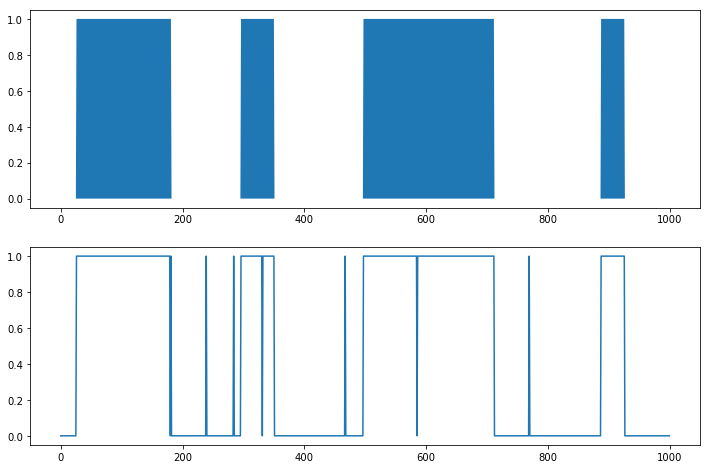

In [902]:
latent_current = [e.label for e in all_elements_new]
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].fill_between(x_pos, latent_1D)
ax[1].plot(x_pos, np.array(latent_current))

# Update distribution parameters

For now: keep $\beta$ constant (later: has to be sampled, as well!)

Step 1: define proposal function

In [654]:
sigma_prop = 0.01

In [675]:
# initialise the proposed value for mu with previous value (or simply 0?)
mu_prev = mu_init
cov_prev = cov_init



mu_proposed = 0 # mu_all[i-1]

In [656]:
# define a sigma jump array:

In [658]:
p = 2 # number of features

sigma_jump = np.zeros((1,p,2))

In [662]:
sigma_jump[:,:,0] = 0.0005 * np.ones((1,p))
sigma_jump[:,:,1] = 0.00005 * np.ones((1,p))

Generate random number array using a multivariate normal sampling:

Set step length for mu and covariance matrices:

In [669]:
# step length for mu and cov
mu_step = 0.0005
cov_step = 0.00005

In [670]:
rv = stats.multivariate_normal(mean=np.zeros(p), cov=np.diag([mu_step, mu_step]))

In [671]:
jump_mu = rv.rvs()

In [672]:
rv_cov = stats.multivariate_normal(mean=np.zeros(p), cov=np.diag([cov_step, cov_step]))

In [715]:
jump_cov = rv_cov.rvs()
jump_cov

array([ 0.00767972,  0.00718503])

In [674]:
# apply jumps:

In [863]:
mu_proposed = mu_prev + jump_mu

Combine in one function:


In [923]:
rv_jump_mu = stats.multivariate_normal(mean=np.zeros(p), cov=np.diag([mu_step, mu_step]))

def propose_mu(mu, rv_jump_mu):
    """Propose new covariance function based on prev. cov and RV for cov. jump
    
    cov : prev. mu matrix
    rv_jump_mu : stats.multivariate_normal object for mu. matrix jump
    
    """
    jump_mu = rv_jump_mu.rvs()
    mu_proposed = mu_prev + jump_mu
    return mu_proposed

In [924]:
mu_proposed = propose_mu(mu_prev, rv_jump_mu)
mu_proposed

array([[  5.98168907,   9.04088215],
       [  4.07966687,  12.12189972]])

Updating the covariance matrix is a lot more complex. Following steps:

1. caculate eigenvalues of (prev) covariance matrix
2. apply cov-jump to diagonal vector
3. apply rotation, adjust eigenvetor



In [716]:
# step 1:
[eigenvals, eigenvec] = np.linalg.eig(cov_prev[0,:,:]) # note: start with cov. matrix for label (0)
eigenvals

array([ 0.43080926,  0.86604177])

In [719]:
D_star = np.diag(np.exp(np.log(eigenvals) + jump_cov))
D_star

array([[ 0.43413049,  0.        ],
       [ 0.        ,  0.87228672]])

Set up "V-star"

This requires a rotation function:

<div class='alert alert-warning'>**Note**: this is only for the 2-D case! Rotation needs to be adjusted later for m-dimensional case (m features)!</div>

In [720]:
# define the jump for the rotation
theta = np.random.normal(0,0.005)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix([[c, -s], [s, c]])

In [721]:
R

matrix([[ 0.99997036,  0.00769966],
        [-0.00769966,  0.99997036]])

In [722]:
V_star = eigenvec @ R # np.dot(eigenvec, R)

In [723]:
V_star

matrix([[-0.73425716, -0.67887143],
        [ 0.67887143, -0.73425716]])

Calculate candidate for this covariance matrix:

In [724]:
cov_cand_label_0 = V_star @ D_star @ V_star.transpose()

In [725]:
cov_cand_label_0

matrix([[ 0.63606198,  0.21840608],
        [ 0.21840608,  0.67035522]])

### Combine generation of covariance candidate:

In [921]:
rv_jump_cov = stats.multivariate_normal(mean=np.zeros(p), cov=np.diag([cov_step, cov_step]))

def propose_cov(cov, rv_jump_cov):
    """Propose new covariance function based on prev. cov and RV for cov. jump
    
    cov : prev. covariance matrix
    rv_jump_cov : stats.multivariate_normal object for cov. matrix jump
    
    """
    jump_cov = rv_jump_cov.rvs()
    cov_proposed = np.empty_like(cov_prev)
    for l in [0,1]:
        [eigenvals, eigenvec] = np.linalg.eig(cov_prev[l,:,:])
        D_star = np.diag(np.exp(np.log(eigenvals) + jump_cov))
        # rotation
        # define the jump for the rotation
        theta = np.random.normal(0,0.005)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix([[c, -s], [s, c]])
        V_star = eigenvec @ R
        cov_proposed[l,:] = V_star @ D_star @ V_star.transpose()
    
    return cov_proposed

Compare to original covariance matrix

In [922]:
cov_proposed = propose_cov(cov_prev, rv_jump_cov)
cov_proposed

array([[[ 0.62783488,  0.21350614],
        [ 0.21350614,  0.6627679 ]],

       [[ 1.08652615,  0.20197311],
        [ 0.20197311,  0.60274959]]])

In [919]:
cov_proposed - cov_prev

array([[[-0.00344505,  0.00037738],
        [ 0.00037738, -0.00651201]],

       [[-0.01137462, -0.0052432 ],
        [-0.0052432 , -0.00557964]]])

## Calculate mixture weight for each element

_Note_: this is now updating the MRF energy based on the new, proposed labels

In [728]:
# calculate MRF energy:
U_MRF = 0.
for n in e1.neighbors:
    if n.label != e1.label:
        U_MRF += beta

In [729]:
U_MRF

0.0

Note: repeat for all elements!

## Acceptance or rejection for proposed mu and sigmas:

calculate likelihood of entire field

pseudo-likelihood:

standard MCMC: compare likleihood of proposed step to likelihood of previous step

mu_prev, cov_prev

<div class='alert alert-warning'>**Important point**: we need to define prior probabilties for our $\mu$ and $\sigma$s. Note: for now, we include here very non-informative priors - however, in reality, these can be narrower (or more specific), for example when some specific information about the feature exists.</div>


Assumption here: 

- the prior for the mean is a multivariate gaussian with a mean corresponding ot the GMM output and a very large covariance:


Define hypterparameters:

In [936]:
rv_mu_0 = stats.multivariate_normal(mu_init[0,:], [[100, 0.],[0., 100]])
rv_mu_1 = stats.multivariate_normal(mu_init[1,:], [[100, 0.],[0., 100]])

**To Do:** implement log normal multivariate distribution directly!

In [937]:
logprob_mean_label_1 = np.log(mean_prior_label_1.pdf(mu_prev[0,:]))
logprob_mean_label_2 = np.log(mean_prior_label_2.pdf(mu_prev[1,:]))
print(logprob_mean_label_1, logprob_mean_label_2)

-6.4430472524 -6.4430472524


In [938]:
# in one function:

def logprob_mu(mu, rv_mu):
    """Log prob for mu for one cluster"""
    return np.log(rv_mu.pdf(mu))
    


In [939]:
logprob_mu(mu_prev[0,:], rv_mu_0)

-6.4430472523974371

**Next difficult step**: define prior for covariance matrices:



In [805]:
def logprob_cov(cov_matrix, d, b, kesi, nu):
    """Caculate log probability of covariance matrix
    
    d: number of features
    parameter for kesi stuff (see Alvarez, 2014):
    b, kesi: shape and skew parameters (papers to be digged out by Jack)
    nu: another funky parameter from Alvarez, 2014
    """
    # calculate lambda
    lam = np.sqrt(np.diag(cov_matrix))
    # calculate R
    R = np.diag(1./lam) @ cov_matrix @ np.diag(1./lam)
    logP_R = -0.5 * (nu + d + 1) * np.log(np.linalg.det(R)) - nu / 2. * np.sum(np.log(np.diag(np.linalg.inv(R))))

    logP_lam = 0.
    for i in range(len(lam)):
        logP_lam += np.log(stats.norm.pdf(lam[i], b[i], kesi[i]))
        
    return logP_R + logP_lam
    
    # logP_lam = np.sum(np.log())


**NOTE**: the calculation of $b$ below is only for one class! **To do**: implement for both!


In [806]:
# parameters
d = 2 # number of features
b = np.log(np.sqrt(np.diag(cov_init[0,:])))
kesi = 100 * np.ones(d)
nu = d+1

logPrior = logprob_cov(cov_prev[0,:], d, b, kesi, nu)

## Now calculate likelihood

Calculate probability _only_ for MRF energy:

In [869]:
U_MRF_all = np.empty((2,1000))

for i,l in enumerate([0,1]):
    for j,e1 in enumerate(all_elements):
        # calculate MRF energy:
        U_MRF = 0.
        for n in e1.neighbors:
            if n.label != l:
                U_MRF += beta
        U_MRF_all[i,j] = U_MRF

    
#U_MRF_all = np.array(U_MRF_all)

In [870]:
U_MRF_all[:,100]

array([ 1.,  0.])

In [871]:
all_elements[99], all_elements[100], all_elements[101]

(Element at pos 99 with values 3.553682, 11.668090, and current label 1,
 Element at pos 100 with values 1.818005, 11.146708, and current label 1,
 Element at pos 101 with values 3.276088, 11.197761, and current label 1)

In [872]:
# local mixture coefficient
alpha = np.exp(- U_MRF_all / T) / np.sum(np.exp(- U_MRF_all / T), axis=0)

In [928]:
def local_mixture_coeff(all_elements, beta):
    """Calculate mixture coefficient matrix
    
    returns alpha(label, element_id)
    """
    
    U_MRF_all = np.empty((2,len(all_elements)))

    for i,l in enumerate([0,1]):
        for j,e1 in enumerate(all_elements):
            # calculate MRF energy:
            U_MRF = 0.
            for n in e1.neighbors:
                if n.label != l:
                    U_MRF += beta
            U_MRF_all[i,j] = U_MRF
            
    # local mixture coefficient
    alpha = np.exp(- U_MRF_all / T) / np.sum(np.exp(- U_MRF_all / T), axis=0)

    return alpha

In [931]:
alpha = local_mixture_coeff(all_elements, beta)
alpha[:,20]

array([ 0.73105858,  0.26894142])

In [874]:
def log_mixture_density(all_elements, mu, cov, alpha):
    """Calculate (log) mixture density for given mean and covariance matrices
    
    mu : mean matrix for all classes and features
    cov : dito
    """
    lmd = 0.
    for j,e in enumerate(all_elements):
        for l in [0,1]:
            lmd += alpha[l,j] * stats.multivariate_normal(mean=mu[l,:], cov=cov[l,:]).pdf(e.values)
    
    return lmd


            
        
    

In [875]:
log_mixture_density(all_elements, mu_prev, cov_prev, alpha)

84.665366322811479

In [876]:
log_mixture_density(all_elements, mu_proposed, cov_proposed, alpha)

84.320987379957955

## Now: complete procedure!


In [941]:
# STEP -1: define parameters
# step length for mu and cov
mu_step = 0.0005
cov_step = 0.00005
# define random variables for jumps
rv_jump_mu = stats.multivariate_normal(mean=np.zeros(p), cov=np.diag([mu_step, mu_step]))
rv_jump_cov = stats.multivariate_normal(mean=np.zeros(p), cov=np.diag([cov_step, cov_step]))



# number of MCMC samples/ chain lenght
n_samples = 100


# STEP 0: Initialisation using GMM

# fit GMM to data (only feature space)
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(observed_field)
# assign labels according to GMM
for i,e in enumerate(all_elements):
    e.update_label(clf)

    
# hyperparameters for funky kesi stuff:
d = 2 # number of features
b = np.log(np.sqrt(np.diag(cov_init[0,:])))
kesi = 100 * np.ones(d)
nu = d+1

# hyperparameters of prior distribution of mu
# separately for each cluster:
mu_cluster_0 = clf.means_[0] # use output of GMM
mu_cluster_1 = clf.means_[1]
mu_std_cluster_0 = [[100, 0.],[0., 100]] # define very wide std.
mu_std_cluster_1 = [[100, 0.],[0., 100]] # define very wide std.

# random variables for proposed new mu in feature space
rv_mu_0 = stats.multivariate_normal(mu_cluster_0, mu_std_cluster_0)
rv_mu_1 = stats.multivariate_normal(mu_cluster_1, mu_std_cluster_1)
# combine in one list
rvs_mu = [rv_mu_0, rv_mu_1]
    
# define output variables
mu_all = []
cov_all = []
# beta_all = []
labels_all = []

# initialise values with GMM fits
mu = clf.means_   # first axis: cluster label, second axis: feature
cov = clf.covariances_ # first axis: cluster label, second and third axes: feature covariances
   
mu_all.append(mu)
cov_all.append(cov)
labels_all.append([e.label[0] for e in all_elements])

In [953]:
for i in range(n_samples):
    
    
    # ************************************************
    # STEP 1: GIBBS SAMPLING (i.e.: update labels)
    # ************************************************
    all_elements = gibbs_sampling(all_elements, mu, cov, beta)
    
    # ************************************************
    # STEP 2: HMRF
    # ************************************************
    cov_proposed = propose_cov(cov, rv_jump_cov)
    mu_proposed = propose_mu(mu, rv_jump_mu)
    # calculate likelihood
    
    # update alpha
    alpha = local_mixture_coeff(all_elements, beta)
    
    # accept/ reject for each cluster separately!
    
    for l in [0,1]:
        # update mixture density - note: in a sense, this is another level of Gibbs sampling!
        lmd_prev = log_mixture_density(all_elements, mu, cov, alpha)
        lmd_proposed = log_mixture_density(all_elements, mu_proposed, cov_proposed, alpha)

        # calculate prior density for mean and cov matrices
        lp_cov_prev = logprob_cov(cov[l,:], d, b, kesi, nu)
        lp_cov_proposed = logprob_cov(cov_proposed[l,:], d, b, kesi, nu)

        lp_mu_prev = logprob_mu(mu[l,:], rvs_mu[l])
        lp_mu_proposed = logprob_mu(mu_proposed[l,:], rvs_mu[l])

        # combine likeihoold and priors:
        log_target_prev = lmd_prev + lp_cov_prev + lp_mu_prev
        log_target_proposed = lmd_proposed + lp_cov_proposed + lp_mu_proposed
        
        # determine acceptance ratio:
        acc_ratio = log_target_proposed / log_target_prev
        
        if (acc_ratio > 1) or (np.random.uniform() < acc_ratio): # accept directly
            mu[l,:] = mu_proposed[l,:]
            cov[l,:] = cov_proposed[l,:]

            
    
    # ************************************************
    # Store newly generated field (or keep previous ones)
    # ************************************************
    mu_all.append(mu)
    cov_all.append(cov)
    labels_all.append([e.label for e in all_elements])
   

In [958]:
la = np.array(labels_all)

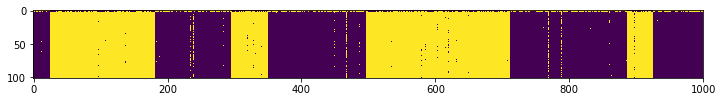

In [960]:
plt.figure(figsize = (12,4))
plt.imshow(la)